In [1]:
import os
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

dir = "./data"
with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
    data = pandas.read_csv(f, header=0, skipinitialspace=True).values
    print(data.shape)


(8036, 7)


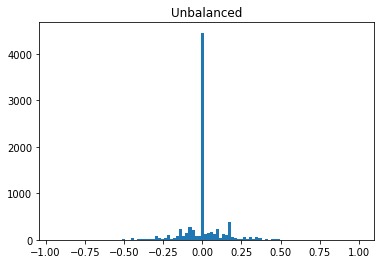

In [2]:
_ = plt.hist(data[:,3], bins=100)
plt.title('Unbalanced')
plt.show()

5923 2113
(2500, 7)


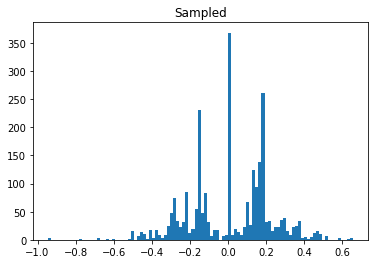

In [3]:
import random

limit = 0.1
nb_normal = 500
nb_extreme = 2000
normal = np.abs(data[:,3]) < limit
extreme = np.abs(data[:,3]) > limit
print(len(data[normal]), len(data[extreme]))
normal_choice = np.random.choice(data[normal].shape[0], nb_normal)
extreme_choice = np.random.choice(data[extreme].shape[0], nb_extreme)
normal_data = data[normal][normal_choice]
extreme_data = data[extreme][extreme_choice]
sampled_data = np.append(normal_data, extreme_data, axis=0)
print(sampled_data.shape)
_ = plt.hist(sampled_data[:,3], bins=100)
plt.title('Sampled')
plt.show()

(7500,) (7500,)


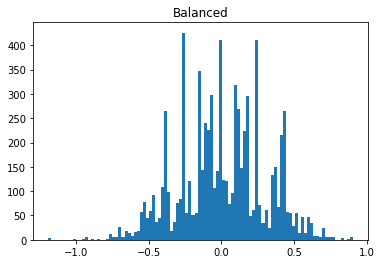

In [4]:
from sklearn.utils import shuffle

c, l, r, st, _, _, _ = np.split(sampled_data, 7, axis=1)
adj = 0.25
balanced_feats = np.append(c, l)
balanced_feats = np.append(balanced_feats, r)
balanced_labels = np.append(st, st + adj)
balanced_labels = np.append(balanced_labels, st - adj)
#balanced_feats, balanced_labels = shuffle(balanced_feats, balanced_labels)
print(balanced_feats.shape, balanced_labels.shape)

_ = plt.hist(balanced_labels, bins=100)
plt.title('Balanced')
plt.show()



In [5]:
span = len(c)
print(balanced_labels[0], balanced_labels[span*1], balanced_labels[span*2])
print(balanced_feats[0], balanced_feats[span*1], balanced_feats[span*2])

print(balanced_labels[span-1], balanced_labels[2*span-1], balanced_labels[3*span-1])
print(balanced_feats[span-1], balanced_feats[2*span-1], balanced_feats[3*span-1])


0.0 0.25 -0.25
IMG/center_2016_12_01_13_35_55_299.jpg IMG/left_2016_12_01_13_35_55_299.jpg IMG/right_2016_12_01_13_35_55_299.jpg
-0.29711609999999994 -0.04711609999999994 -0.5471161
IMG/center_2016_12_01_13_39_31_473.jpg IMG/left_2016_12_01_13_39_31_473.jpg IMG/right_2016_12_01_13_39_31_473.jpg


[1861 5083 3937]
[0.4923438 -0.25 0.5988158]
(7500,)


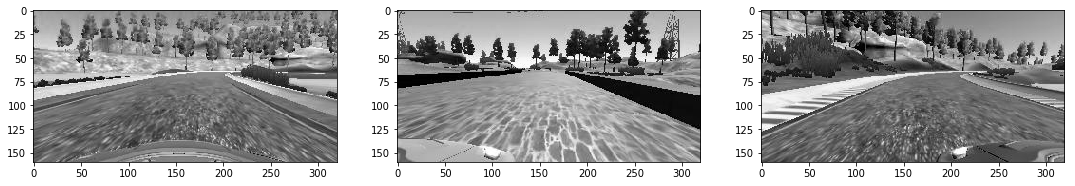

In [6]:
import cv2

image_features = np.array([
        cv2.cvtColor(cv2.imread(os.path.join(dir, f)), cv2.COLOR_BGR2YUV)[:,:,0:1]
    for f in balanced_feats])
image_labels = balanced_labels
samples = np.random.choice(image_features.shape[0], 3)
print(samples)
f = plt.figure(figsize=(25,14))
for i in range(len(samples)): 
    s = f.add_subplot(2,4,i+1)
    s.imshow(image_features[samples[i]][:,:,0], cmap='gray')
print(image_labels[samples])
print(image_features.shape)
plt.show()

(8130, 160, 320, 1) (8130,)


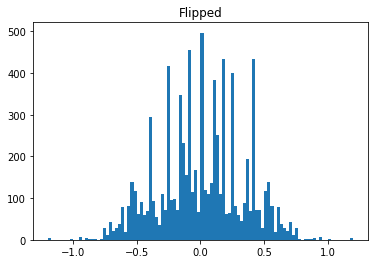

In [7]:
flip_limit = 0.5
flip = np.logical_or(image_labels < -flip_limit, image_labels > flip_limit)
flipped_feats = [np.fliplr(f) for f in image_features[flip]]
features = np.append(image_features, flipped_feats, axis=0)
labels = np.append(image_labels, -image_labels[flip], axis=0)
print(features.shape, labels.shape)

_ = plt.hist(labels, bins=100)
plt.title('Flipped')
plt.show()


0.6454403000000001 -0.6454403000000001


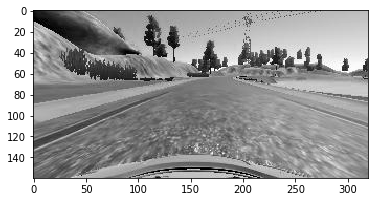

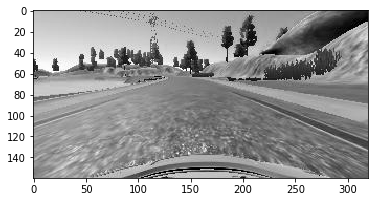

In [8]:
print(image_labels[flip][0], labels[len(image_labels)])
plt.imshow(image_features[flip][0][:,:,0], cmap='gray')
plt.figure()
plt.imshow(features[len(image_features)][:,:,0], cmap='gray')
plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

X_train, y_train = shuffle(features, labels)
print(X_train.shape[1:])

def my_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=X_train.shape[1:]))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='c1'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='c2'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    
    model.add(Convolution2D(128, 5, 5, border_mode='same', activation='relu', name='c3'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='d1'))
    model.add(Dense(64, activation='linear', name='d2'))
    model.add(Dense(16, activation='relu', name='d3'))
    model.add(Dense(1, activation='linear', name='out'))
    
    return model

def nvidia_model():
    model = Sequential()
    #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(66, 200, 3)))    
    model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='relu', name='c1', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu', name='c2', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu', name='c3', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', name='c4'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', name='c5'))
    model.add(Dropout(0.2))
    model.add(Flatten())
#     model.add(Dense(1164, name='d1'))
#     model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu', name='d2'))
    model.add(Dropout(0.5))    
    model.add(Dense(50, activation='relu', name='d3'))
    model.add(Dense(10, activation='relu', name='d4'))
    model.add(Dropout(0.5))        
    model.add(Dense(1, name='out'))

    return model

#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.01, random_state = 0)

model = my_model()
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
model.compile(optimizer=adam, loss='mse')

history = model.fit(X_train, y_train, batch_size=32, nb_epoch=5, verbose=2, validation_split=0.05)

# datagen = ImageDataGenerator()
# datagen.fit(X_train)
# history = model.fit_generator(
#     datagen.flow(X_train, y_train, batch_size=32),
#     samples_per_epoch=X_train.shape[0],
#     nb_epoch=8,
#     validation_data=(X_validation, y_validation),
#     )

y_pred = model.predict(X_train)
print(model.save("model.new.h5"))


(160, 320, 1)
Train on 7723 samples, validate on 407 samples
Epoch 1/5
80s - loss: 0.0567 - val_loss: 0.0735
Epoch 2/5
75s - loss: 0.0362 - val_loss: 0.0669
Epoch 3/5
75s - loss: 0.0329 - val_loss: 0.0643
Epoch 4/5
75s - loss: 0.0304 - val_loss: 0.0621
Epoch 5/5
75s - loss: 0.0287 - val_loss: 0.0602
None


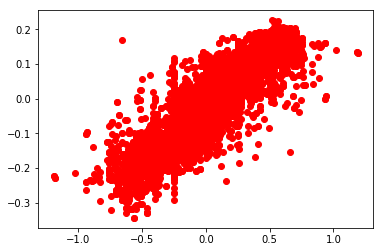

[-0.34401864] [ 0.22596903]


In [21]:
plt.plot(y_train, y_pred, 'ro')
plt.show()
print(np.min(y_pred, axis=0), np.max(y_pred, axis=0))

